In [1]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec

startTime = 3.0

pktPayloadSize = 1460 # Bytes
hdrSize = 40 # Bytes
mtu = pktPayloadSize + hdrSize

torBw = 10e9 # bps
baseRtt = 6e-6 # seconds
bdpPkts = torBw * baseRtt / 8 / mtu # packets

In [2]:
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

# Importing MsgTrace Data

In [3]:
msgTraceData = {}
msgIds = []

with open("ReceiverEval-MsgTraces.tr",'r') as f:
    for line in f:
        msgLog = line.split()

        time = float(msgLog[1])*1e-9 -startTime   # in seconds
        msgSize = int(msgLog[2])                  # in bytes
        sender = msgLog[3]                        # ip:port
        receiver = msgLog[4]                      # ip:port
        txMsgId = int(msgLog[5])

        key = receiver.split(':')[1] # DstPort

        if (msgLog[0]=='+'):
            msgIds.append(key)
            msgTraceData[key] = {}
            msgTraceData[key]['size'] = msgSize
            msgTraceData[key]['start'] = time

        elif (msgLog[0] =='-'):
            msgTraceData[key]['finish'] = time

# Importing PktTrace Data

In [4]:
pktTraceData = {}

with open("ReceiverEval-PktTraces.tr",'r') as f:
    for line in f:
        pktLog = line.split()

        time = float(pktLog[0])*1e-9 -startTime # in seconds
        sender = pktLog[1]                      # ip:port
        receiver = pktLog[2]                    # ip:port
        txMsgId = int(pktLog[3])
        pktOffset = int(pktLog[4])
        prio = int(pktLog[5])
        
        key = receiver.split(':')[1] # DstPort
        
        if (key not in pktTraceData):
            pktTraceData[key] = {}
            pktTraceData[key]['times'] = []
            pktTraceData[key]['offsets'] = []
            pktTraceData[key]['prios'] = []
            
        pktTraceData[key]['times'].append(time)
        pktTraceData[key]['offsets'].append(pktOffset)
        pktTraceData[key]['prios'].append(prio)

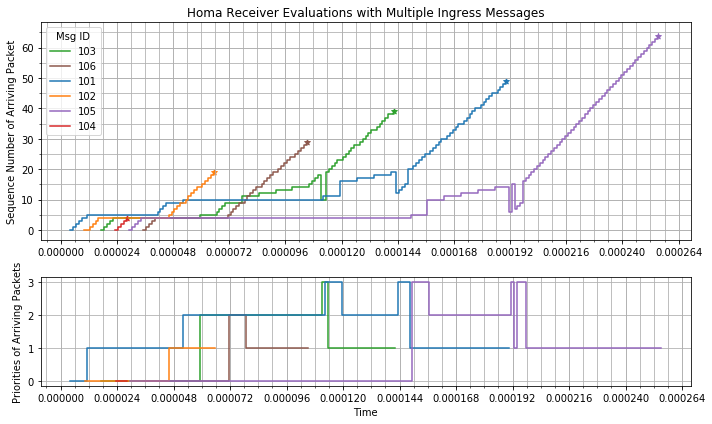

In [7]:
fig = plt.figure(figsize=(10,6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax0 = plt.subplot(gs[0])

for key, val in pktTraceData.items():
    plt.step(val['times'], val['offsets'], label=key, 
             c="C"+str(msgIds.index(key)), where='post')
    
for key, val in msgTraceData.items():
    plt.scatter(val['finish'], val['size']/pktPayloadSize-1,
                marker='*', c="C"+str(msgIds.index(key)))

plt.title('Homa Receiver Evaluations with Multiple Ingress Messages')
plt.ylabel('Sequence Number of Arriving Packet')
ax0.legend(title='Msg ID')
ax0.yaxis.set_minor_locator(MultipleLocator(bdpPkts))
ax0.xaxis.set_minor_locator(MultipleLocator(baseRtt))
ax0.xaxis.set_major_locator(MultipleLocator(4*baseRtt))
ax0.grid(which='both')
# plt.xlim([0,0.000154])
plt.tight_layout()

ax1 = plt.subplot(gs[1])
for key, val in pktTraceData.items():
    plt.step(val['times'], val['prios'], label=key, 
             c="C"+str(msgIds.index(key)), where='post')
    
plt.ylabel('Priorities of Arriving Packets')
plt.xlabel('Time')
ax1.xaxis.set_minor_locator(MultipleLocator(baseRtt))
ax1.xaxis.set_major_locator(MultipleLocator(4*baseRtt))
ax1.grid(which='both')
# plt.xlim([0,0.000154])
plt.tight_layout()

plt.show()